In the section 02 section, we tried to use K-means to classify some fruit images. However, we weren't very successful. It is because the "color vectors" obtained for the pixels of the image, that we were trying to use to classify the images, weren't very appropriate to describe pretty much anything that is not just color. 

At the same time, in the section 03 we saw that we can describe images using CNNs, and we trained a network to distinguish objects not only by their colors but also by their form. In the end, we were able to obtain feature vectors that we were "adding" in to 10 values to get a final one hot representation. However, before the final addition, what we have is a vector of visual features of the image, that we can use to try to find clusters in our images. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from himage import multimshow

2024-01-31 06:49:02.649822: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 06:49:02.779263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 06:49:02.779324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 06:49:02.807980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 06:49:02.863173: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 06:49:02.864612: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

labels = np.unique(y_train)

# we normalize the data to be between 0 and 1
x_train_f = x_train.astype('float') / 255.
x_test_f = x_test.astype('float') / 255.

# we also convert the labels to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=labels.size)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=labels.size)

# we initialize the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# we define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))) 
model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(128, activation='relu')) 
model.add(tf.keras.layers.Dense(labels.size, activation='softmax')) 

# we compile and fit the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_f, y_train_oh, epochs=40, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# we evaluate the model
test_loss, test_acc = model.evaluate(x_test_f, y_test_oh)
print('Test accuracy:', test_acc)

Epoch 1/40
1407/1407 [==============================] - 39s 27ms/step - loss: 1.4802 - accuracy: 0.4620 - val_loss: 1.1872 - val_accuracy: 0.5846
Epoch 2/40
1407/1407 [==============================] - 37s 26ms/step - loss: 1.0736 - accuracy: 0.6221 - val_loss: 1.0504 - val_accuracy: 0.6248
Epoch 3/40
1407/1407 [==============================] - 35s 25ms/step - loss: 0.9026 - accuracy: 0.6844 - val_loss: 0.8818 - val_accuracy: 0.6892
Epoch 4/40
1407/1407 [==============================] - 34s 24ms/step - loss: 0.7895 - accuracy: 0.7245 - val_loss: 0.8436 - val_accuracy: 0.7040
Epoch 5/40
1407/1407 [==============================] - 37s 27ms/step - loss: 0.7003 - accuracy: 0.7558 - val_loss: 0.8467 - val_accuracy: 0.7066
Epoch 6/40
1407/1407 [==============================] - 51s 36ms/step - loss: 0.6195 - accuracy: 0.7827 - val_loss: 0.8302 - val_accuracy: 0.7202
Epoch 7/40
1407/1407 [==============================] - 53s 38ms/step - loss: 0.5540 - accuracy: 0.8045 - val_loss: 0.8165 -

In [3]:
# lets remove the last layer to have a model that outputs the features
model_features = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [4]:
# lets see wat the features look like
features = model_features.predict(x_test_f)
print(features.shape)

313/313 [==============================] - 3s 8ms/step
(10000, 128)


Lets also integrate the code from the section 02 that we need to load the fruit images

In [5]:
from PIL import Image
import numpy as np 
import os

SMALL_SIZE = 32
DATA_DIR = '../data'

# increase the maximum number of open files so that os can read the all the images in the directory
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (10000, 10000))

def resize(im, size=SMALL_SIZE):
    """Resize an image to the given size"""
    im = im.resize((size, size))
    return im

def load_images(path = os.path.join(DATA_DIR, "fruits")):
    """Load the data from the given path"""
    res = []
    res_small = []
    for filename in os.listdir(path):
        img = Image.open(os.path.join(path, filename))
        img = img.convert("RGB")
        res_small.append(np.array(resize(img, SMALL_SIZE)))
    return np.array(res_small)

data_small = load_images()

In [6]:
# we than extract the features from the fruit images
fruit_fratures = model_features.predict(data_small)

print(fruit_fratures.shape)

175/313 [===============>..............] - ETA: 1s

313/313 [==============================] - 5s 14ms/step
(10000, 128)


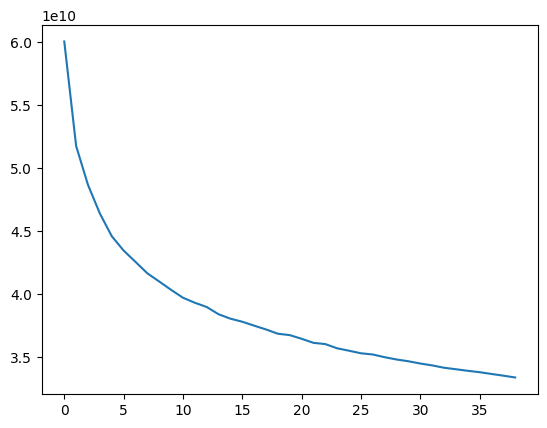

In [16]:
# now let's use kmeans to cluster the feature vectors with different number of clusters
from sklearn.cluster import KMeans

# we first normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(fruit_fratures)

# use inertia to find the best number of clusters
inertia = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 'auto').fit(fruit_fratures)
    inertia.append(kmeans.inertia_)
plt.plot(inertia)
plt.show()


We see the same descending curve withouth visible minimum reached. It is because the more clusters we add, the more they we reduce the size of our clusters, which reduces the inertia. 

Cluster 0


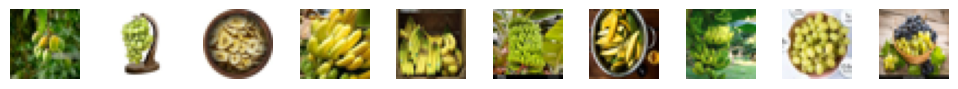

Cluster 1


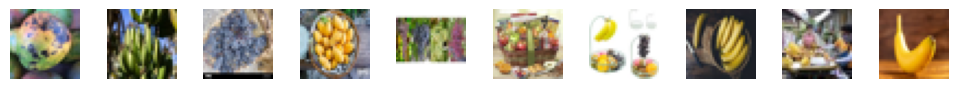

Cluster 2


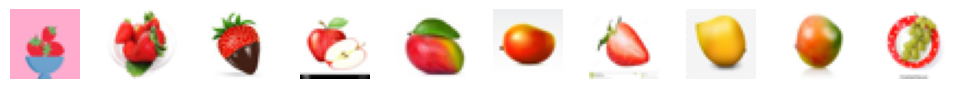

Cluster 3


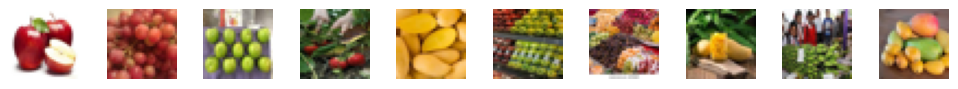

Cluster 4


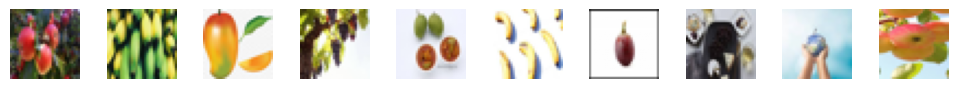

Cluster 5


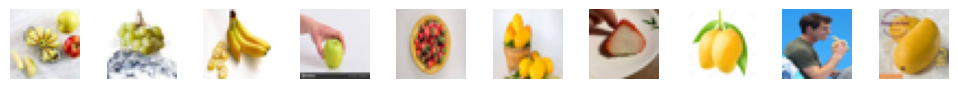

Cluster 6


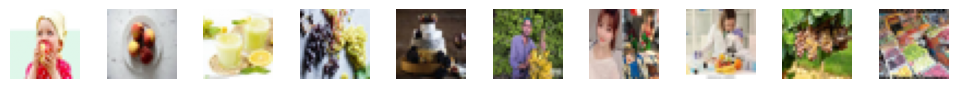

Cluster 7


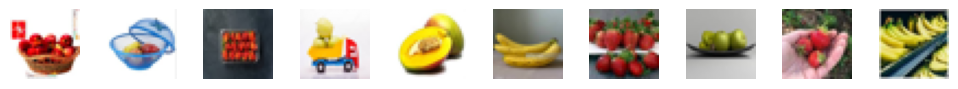

Cluster 8


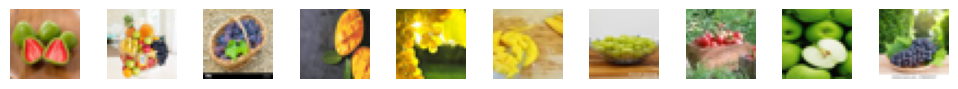

Cluster 9


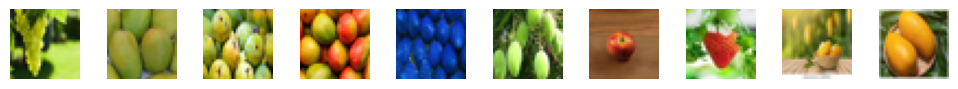

Cluster 10


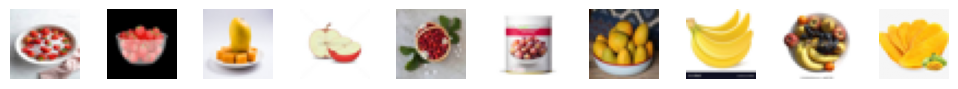

Cluster 11


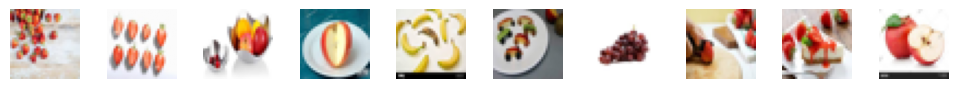

Cluster 12


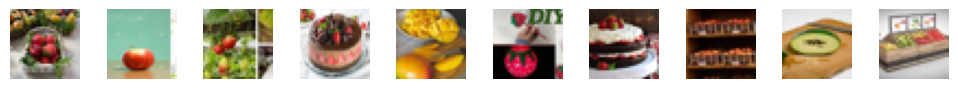

Cluster 13


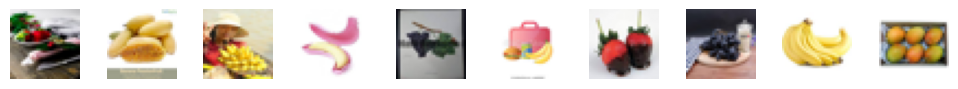

Cluster 14


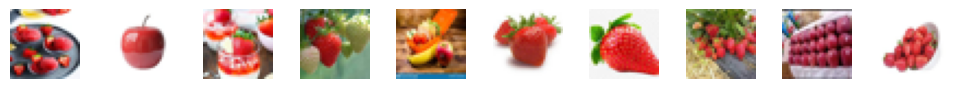

Cluster 15


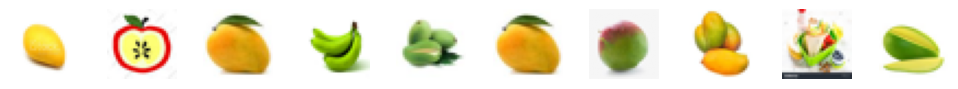

Cluster 16


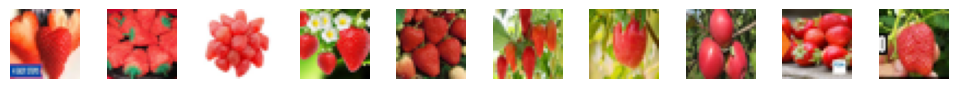

Cluster 17


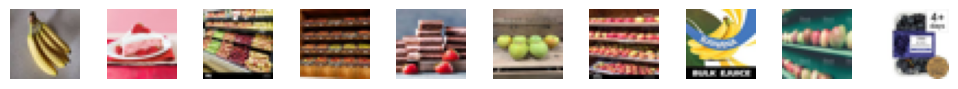

Cluster 18


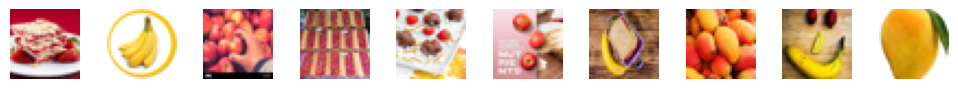

Cluster 19


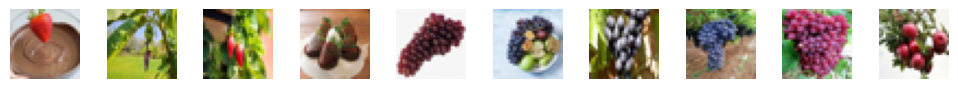

Cluster 20


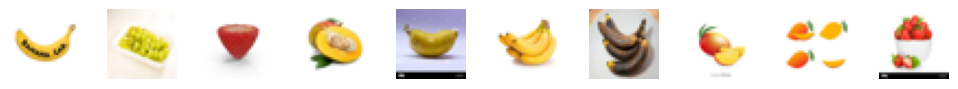

Cluster 21


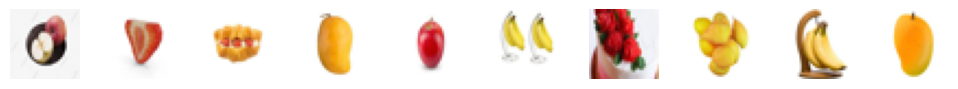

Cluster 22


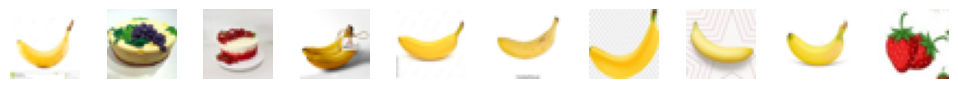

Cluster 23


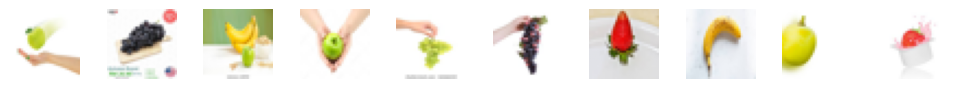

Cluster 24


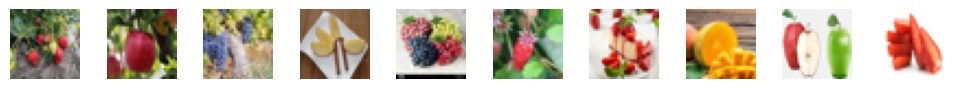

Cluster 25


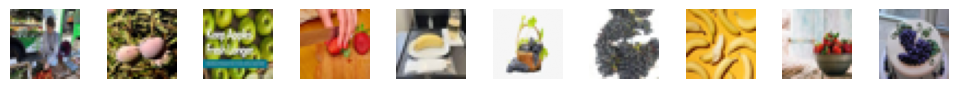

Cluster 26


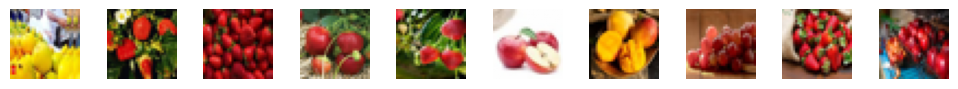

Cluster 27


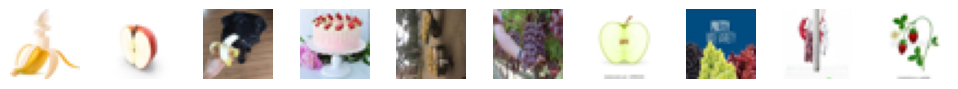

Cluster 28


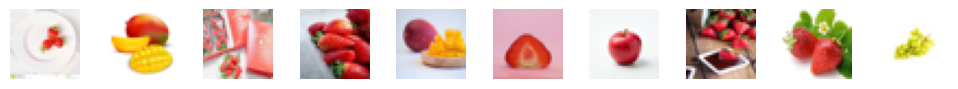

Cluster 29


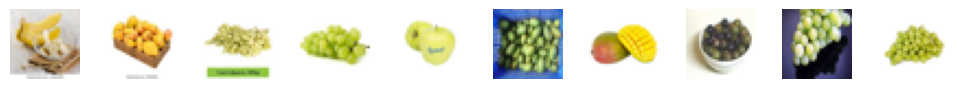

Cluster 30


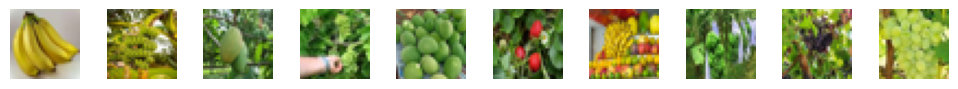

Cluster 31


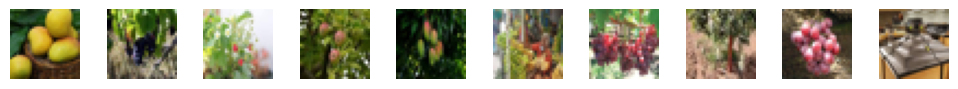

Cluster 32


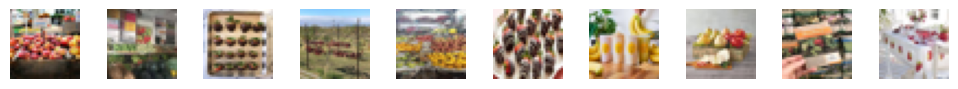

Cluster 33


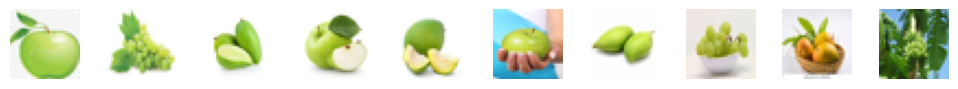

Cluster 34


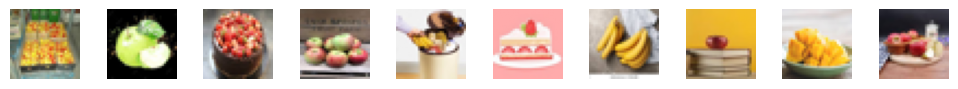

Cluster 35


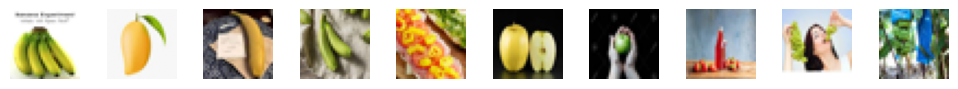

Cluster 36


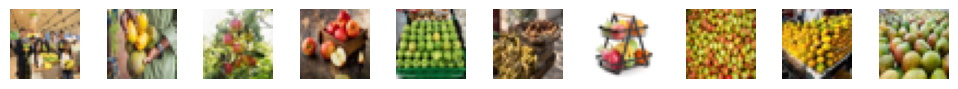

Cluster 37


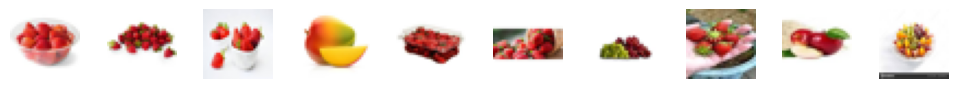

Cluster 38


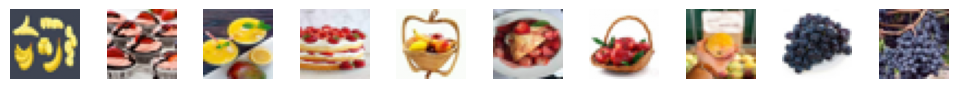

Cluster 39


<Figure size 1000x0 with 0 Axes>

In [17]:
# display 10 first images from each cluster for data with 40 clusters
for i in range(40):
    print("Cluster", i)
    multimshow(data_small[kmeans.labels_ == i][:10], n_cols=10)

Even though the color seem to have an important impact on the classification, it seems that the forms of the objects have also influenced the clusters. For example the cluster 2 seem to have grouped the images that represent a red shape with some green, or the cluster 9 has grouped shapes with repeating round shapes, the cluster 17 that groups images with lines